<a href="https://colab.research.google.com/github/sachinagnihotri/Natural-Language-Processing/blob/main/E4_Bi_LSTM%2C_GRU_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#With Early Stopping

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Conv1D, GlobalMaxPooling1D, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import random
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
tf.keras.utils.set_random_seed(seed)
from tensorflow.keras import backend as K
K.clear_session()

# Parameters
max_words = 40000    # top 40k frequent words
max_len = 200        # pad/truncate reviews to 200 tokens
embedding_dim = 200  # embedding vector size

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)

# Pad both train and test before concatenation
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

# Combine for full dataset
x_full = np.concatenate((x_train, x_test), axis=0)
y_full = np.concatenate((y_train, y_test), axis=0)

# Split validation data
val_size = 10000
x_val = x_full[:val_size]
y_val = y_full[:val_size]
x_train_full = x_full[val_size:]
y_train_full = y_full[val_size:]

print(f"Training samples: {len(x_train_full)}, Validation samples: {len(x_val)}")


Training samples: 40000, Validation samples: 10000


In [29]:
import matplotlib.pyplot as plt

def plot_learning_curves(histories, model_names):
    plt.figure(figsize=(14, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [30]:
import time
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Build Bi-LSTM model
def build_bilstm():
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_len),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

# Train Bi-LSTM
bilstm_model = build_bilstm()

start_time = time.time()
history_bilstm = bilstm_model.fit(
    x_train_full, y_train_full,
    epochs=50,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)
bilstm_train_time = time.time() - start_time






Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.5088 - loss: 0.6930 - val_accuracy: 0.5567 - val_loss: 0.6913
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5819 - loss: 0.6881 - val_accuracy: 0.6493 - val_loss: 0.6189
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.7451 - loss: 0.5272 - val_accuracy: 0.8397 - val_loss: 0.3750
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.8542 - loss: 0.3550 - val_accuracy: 0.8644 - val_loss: 0.3217
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.8796 - loss: 0.2987 - val_accuracy: 0.8761 - val_loss: 0.2965
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.8939 - loss: 0.2653 - val_accuracy: 0.8822 - val_loss: 0.2854
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.9066 - loss: 0.2422 - val_accuracy: 0.8860 - val_loss: 0.2797
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.9150 - loss: 0.2243 - 

In [31]:
# Evaluate
train_loss, train_acc = bilstm_model.evaluate(x_train_full, y_train_full, verbose=0)
print(f"Bi-LSTM Train Accuracy: {train_acc:.4f}")
test_loss, test_acc = bilstm_model.evaluate(x_test, y_test, verbose=0)
print(f"Bi-LSTM Test Accuracy: {test_acc:.4f}")
print(f"Training Time: {bilstm_train_time:.2f} seconds")

Bi-LSTM Train Accuracy: 0.9340
Bi-LSTM Test Accuracy: 0.9356
Training Time: 549.69 seconds


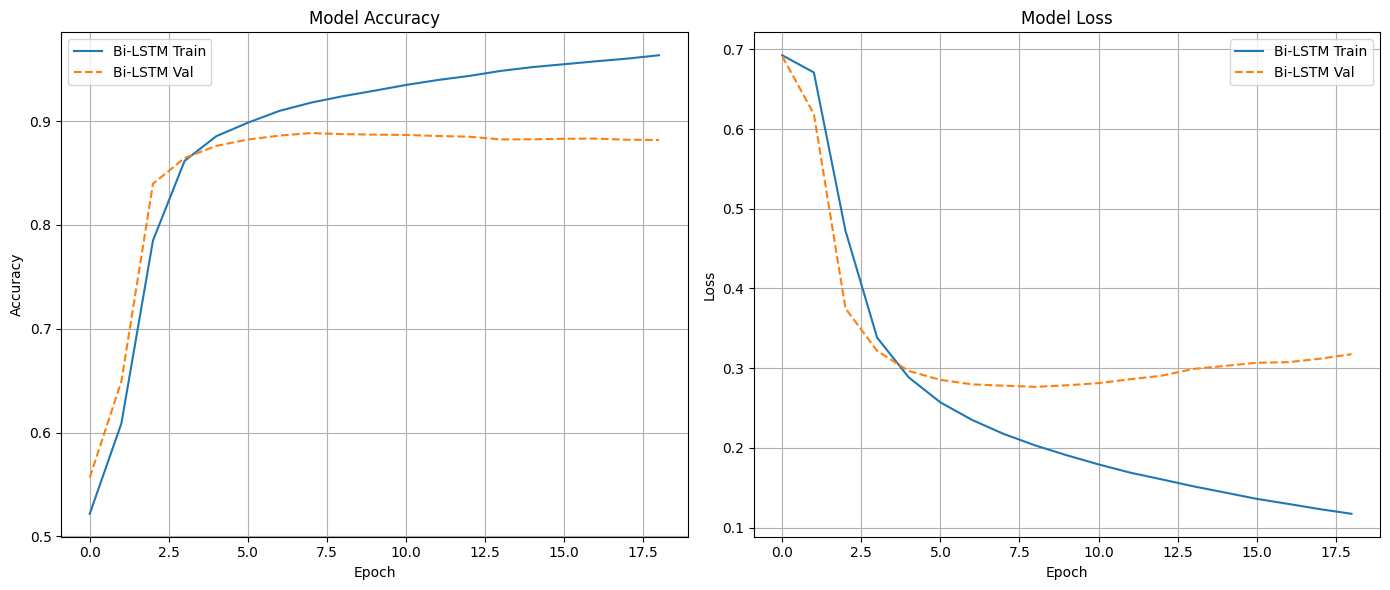

In [32]:
# Plot learning curves
plot_learning_curves([history_bilstm], ["Bi-LSTM"])

In [33]:
# Build Bi-GRU model
def build_bigru():
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_len),
        Bidirectional(GRU(256, return_sequences=False)),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

# Train Bi-GRU
bigru_model = build_bigru()

start_time = time.time()
history_bigru = bigru_model.fit(
    x_train_full, y_train_full,
    epochs=50,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)
bigru_train_time = time.time() - start_time






Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.5115 - loss: 0.6927 - val_accuracy: 0.5563 - val_loss: 0.6907
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.5714 - loss: 0.6889 - val_accuracy: 0.5846 - val_loss: 0.6824
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.6200 - loss: 0.6655 - val_accuracy: 0.7624 - val_loss: 0.4826
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.8135 - loss: 0.4125 - val_accuracy: 0.8356 - val_loss: 0.3595
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.8691 - loss: 0.3114 - val_accuracy: 0.8667 - val_loss: 0.3087
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.8911 - loss: 0.2690 - val_accuracy: 0.8800 - val_loss: 0.2849
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.9021 - loss: 0.2420 - val_accuracy: 0.8846 - val_loss: 0.2774
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.9127 - loss: 0.2231 - 

In [34]:
# Evaluate
test_loss, test_acc = bigru_model.evaluate(x_test, y_test, verbose=0)
print(f"Bi-GRU Test Accuracy: {test_acc:.4f}")
print(f"Training Time: {bigru_train_time:.2f} seconds")
g_train_loss, G_train_acc = bigru_model.evaluate(x_train_full, y_train_full, verbose=0)
print(f"Bi-GRU Train Accuracy: {G_train_acc:.4f}")

Bi-GRU Test Accuracy: 0.9295
Training Time: 445.31 seconds
Bi-GRU Train Accuracy: 0.9270


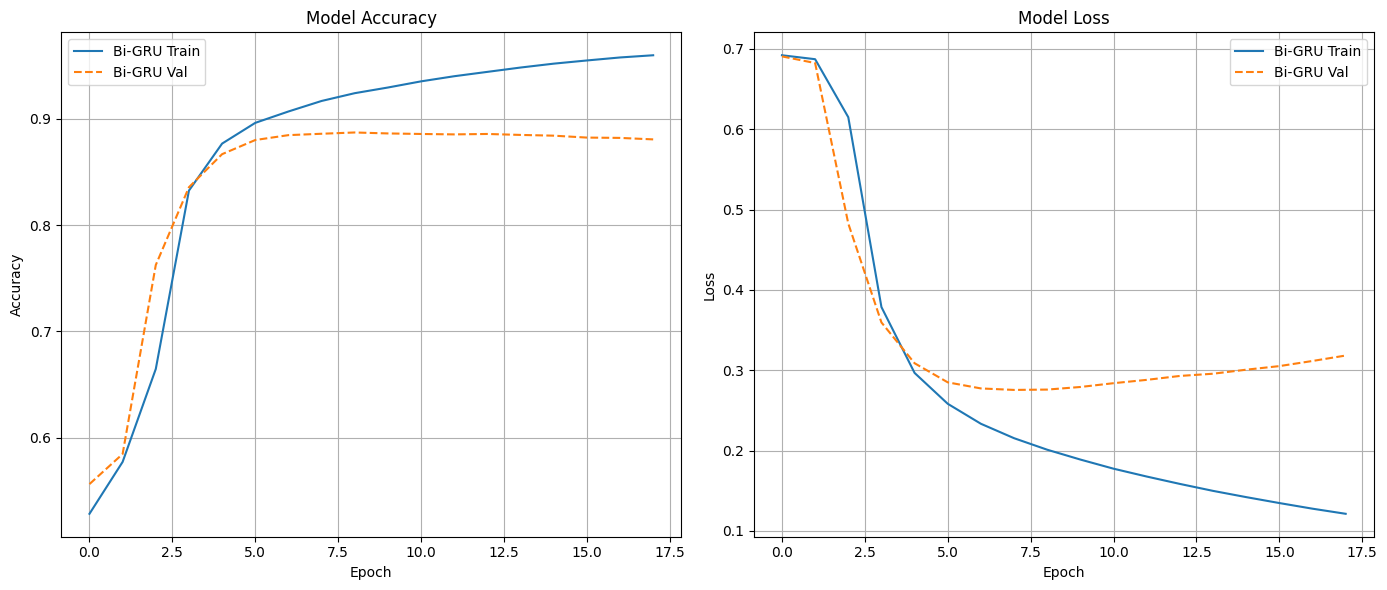

In [35]:
# Plot learning curves
plot_learning_curves([history_bigru], ["Bi-GRU"])